<a href="https://colab.research.google.com/github/crisgc/0519-Course-Machine-Learning/blob/main/0263_exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Exercício de Machine Learning - Redes Neurais para Aproximação de Funções

## Introdução

Neste exercício, vamos explorar o funcionamento de uma rede neural artificial simples. A rede foi projetada para aproximar a função seno, ou seja, aprender a representar a relação entre entradas e saídas que seguem o padrão da função seno. Através desse exercício, você será capaz de entender os conceitos básicos do treinamento de redes neurais e como diferentes parâmetros afetam seu desempenho.

# Objetivo

A rede neural que vamos utilizar aqui é um modelo de aprendizado supervisionado, que aprende a partir de exemplos de entrada e saída (pares de dados). Nosso objetivo é que a rede seja capaz de prever o valor de uma função seno dada uma entrada específica, mesmo quando os dados de entrada estejam contaminados com algum ruído (para simular situações reais, onde os dados nem sempre são perfeitos).

# Estrutura do Exercício

Ao longo do notebook, você encontrará tarefas práticas que vão guiá-lo através dos principais conceitos de treinamento de redes neurais. Essas tarefas vão permitir que você:

	1.	Modifique funções de ativação para entender como elas impactam o aprendizado.
	2.	Ajuste o número de épocas para observar a convergência da rede.
	3.	Experimente diferentes taxas de aprendizado para ver como elas afetam a estabilidade e a rapidez do treinamento.
	4.	Altere a quantidade de neurônios e camadas para explorar a capacidade da rede de representar padrões complexos.
	5.	Aplique regularização para melhorar a capacidade da rede de generalizar para novos dados.

Cada tarefa inclui uma descrição do que precisa ser feito e instruções sobre como modificar o código e visualizar os resultados. O propósito é que você possa experimentar com a rede neural, observar os resultados das suas alterações e desenvolver uma compreensão intuitiva de como esses parâmetros afetam o comportamento do modelo.

# O que Você Vai Aprender

Ao completar este exercício, você terá um entendimento básico de como redes neurais processam informações, ajustam seus parâmetros e fazem previsões. Além disso, você entenderá melhor como configurá-las para resolver problemas práticos, como aproximação de funções e predição em cenários com ruído.

Vamos começar e observar como essa rede neural simples pode aprender a forma de uma função seno!

In [2]:
#Importação de Bibliotecas e Configurações Iniciais

import numpy as np
import matplotlib.pyplot as plt
import arrow

# Parâmetros principais
SEED = 42
N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 1]
LEARNING_RATE = 0.05
N_EPOCHS = 10000

# Configuração da semente aleatória
np.random.seed(SEED)

# Geração dos dados de entrada e saída com ruído
x_samples = np.random.uniform(0, 2 * np.pi, (1, N_SAMPLES))
y_samples = np.sin(x_samples) + np.random.normal(0.0, 0.3, (1, N_SAMPLES))

Aqui, definimos várias funções de ativação que a rede neural pode usar: sigmoid, gelu, identity (para a camada de saída), e relu. Em seguida, criamos a função initialize_network, que configura a rede neural, inicializando os pesos, os vieses e associando a função de ativação a cada camada.

In [3]:
# Definição de funções de ativação

def sigmoid(x):
    """Função Sigmoide."""
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(z):
    """Derivada da função Sigmoide em relação a z."""
    a = sigmoid(z)
    return a * (1 - a)


def gelu(x):
    """Função de ativação GELU."""
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def gelu_prime(z):
    """Derivada da função GELU em relação a z."""
    sqrt_2_over_pi = np.sqrt(2 / np.pi)
    term = sqrt_2_over_pi * (z + 0.044715 * np.power(z, 3))
    tanh_out = np.tanh(term)
    return 0.5 * (1 + tanh_out + z * (1 - tanh_out**2) * (sqrt_2_over_pi + 0.134145 * z**2))

def identity(x):
    """Função identidade, utilizada na camada de saída."""
    return x

def identity_prime(z):
    """Derivada da função identidade em relação a z."""
    return np.ones_like(z)

def relu(x):
    """Função de ativação ReLU."""
    return np.maximum(0, x)

def relu_prime(z):
    """Derivada da função ReLU em relação a z."""
    return (z > 0).astype(float)

# Inicializando a rede neural com funções de ativação como parâmetros

def initialize_network(layers, activation_function, activation_derivative):
    """
    Inicializa a rede neural com a arquitetura especificada, função de ativação e sua derivada.

    Args:
        layers (list): Lista contendo o número de neurônios em cada camada.
        activation_function (function): Função de ativação a ser usada nas camadas ocultas.
        activation_derivative (function): Derivada da função de ativação.

    Returns:
        weight_matrices (list): Lista de matrizes de pesos.
        bias_vectors (list): Lista de vetores de bias.
        activation_functions (list): Lista de funções de ativação para cada camada.
        activations_derivatives (list): Lista de derivadas das funções de ativação para cada camada.
    """
    weight_matrices = []
    bias_vectors = []
    activation_functions = [activation_function] * (len(layers) - 2) + [identity]  # Define as ativações
    activations_derivatives = [activation_derivative] * (len(layers) - 2) + [identity_prime]  # Define as derivadas

    for fan_in, fan_out in zip(layers[:-1], layers[1:]):
        kernel_matrix_uniform_limit = np.sqrt(6 / (fan_in + fan_out))
        W = np.random.uniform(-kernel_matrix_uniform_limit, kernel_matrix_uniform_limit, (fan_out, fan_in))
        b = np.zeros((fan_out, 1))
        weight_matrices.append(W)
        bias_vectors.append(b)

    return weight_matrices, bias_vectors, activation_functions, activations_derivatives

# Funções de Passagem para Frente (Forward) e Cálculo da Perda

Implementamos duas funções importantes:

	1) network_forward: executa a passagem para frente (forward pass) da rede, calculando a saída final da rede.
	2 )loss_forward: calcula a perda (erro) entre a saída da rede e o valor real, usando o erro quadrático médio e um termo de regularização L2 opcional.

In [4]:
def network_forward(x, weights, biases, activations):
    """
    Executa a passagem para frente da rede neural.

    Args:
        x (numpy.ndarray): Entrada para a rede.
        weights (list): Lista de matrizes de pesos.
        biases (list): Lista de vetores de bias.
        activations (list): Lista de funções de ativação para cada camada.

    Returns:
        a (numpy.ndarray): Saída final da rede.
    """
    a = x
    for W, b, activation in zip(weights, biases, activations):
        z = np.dot(W, a) + b
        a = activation(z)
    return a

def loss_forward(y, y_ref, weights=None, lambda_l2=0):
    """
    Calcula a perda entre a saída da rede e o valor real.

    Args:
        y (numpy.ndarray): Saída da rede.
        y_ref (numpy.ndarray): Valor real.
        weights (list, optional): Lista de matrizes de pesos para regularização L2.
        lambda_l2 (float, optional): Fator de regularização L2.

    Returns:
        loss (float): Valor da perda.
    """
    delta = y - y_ref
    loss = 0.5 * np.mean(np.sum(delta ** 2, axis=0))
    if lambda_l2 > 0 and weights is not None:
        l2_penalty = lambda_l2 * sum(np.sum(W ** 2) for W in weights)
        loss += l2_penalty
    return loss


# **Função de Backpropagation**

A função network_forward_and_backward calcula o processo de backpropagation, que permite ajustar os pesos e vieses da rede. Ela realiza a passagem para trás (backward pass), calculando os gradientes da função de perda em relação aos parâmetros da rede, para que possam ser atualizados durante o treinamento.

In [5]:
def network_forward_and_backward(x, y_ref, weights, biases, activations, activations_derivatives, lambda_l2=0):
    """
    Executa a passagem para frente e o backpropagation, calculando os gradientes.

    Args:
        x (numpy.ndarray): Entrada para a rede.
        y_ref (numpy.ndarray): Valor real.
        weights (list): Lista de matrizes de pesos.
        biases (list): Lista de vetores de bias.
        activations (list): Lista de funções de ativação para cada camada.
        activations_derivatives (list): Lista de derivadas das funções de ativação para cada camada.
        lambda_l2 (float, optional): Fator de regularização L2.

    Returns:
        loss (float): Valor da perda.
        weight_gradients (list): Lista de gradientes dos pesos.
        bias_gradients (list): Lista de gradientes dos bias.
    """
    # Passagem para frente
    a = x
    layer_values = [a]
    z_values = []  # Lista para armazenar os valores de z

    for W, b, activation in zip(weights, biases, activations):
        z = np.dot(W, a) + b
        a = activation(z)
        z_values.append(z)
        layer_values.append(a)

    y = a
    loss = loss_forward(y, y_ref, weights, lambda_l2)

    # Passagem para trás (backpropagation)
    current_cotangent = (y - y_ref) / y.shape[1]  # Gradiente da camada de saída
    weights_gradients = []
    bias_gradients = []

    # Retropropagação dos gradientes
    for W, activation_prime, z_current, a_prev in zip(
            reversed(weights), reversed(activations_derivatives),
            reversed(z_values), reversed(layer_values[:-1])):

        # Calcula o gradiente com base no pré-ativação z_current
        plus_bias_state_cotangent = current_cotangent * activation_prime(z_current)

        # Gradiente do bias
        bias_grad = np.sum(plus_bias_state_cotangent, axis=1, keepdims=True)
        bias_gradients.append(bias_grad)

        # Gradiente dos pesos com regularização L2 adicionada
        weight_grad = np.dot(plus_bias_state_cotangent, a_prev.T) + lambda_l2 * W
        weights_gradients.append(weight_grad)

        # Atualiza o cotangent para a próxima camada
        current_cotangent = np.dot(W.T, plus_bias_state_cotangent)

    # Inverte as listas de gradientes para manter a ordem original das camadas
    return loss, list(reversed(weights_gradients)), list(reversed(bias_gradients))


A função train_network utiliza as funções anteriores para treinar a rede neural ao longo de múltiplas épocas, atualizando os pesos e vieses com base nos gradientes calculados na função de backpropagation.

In [6]:
def train_network(n_epochs, learning_rate, activation_functions, activations_derivatives, weights, biases, lambda_l2=0):
    """
    Treina a rede neural por um número especificado de épocas.

    Args:
        n_epochs (int): Número de épocas para o treinamento.
        learning_rate (float): Taxa de aprendizado.
        activation_functions (list): Lista de funções de ativação para cada camada.
        activations_derivatives (list): Lista de derivadas das funções de ativação para cada camada.
        weights (list): Lista de matrizes de pesos.
        biases (list): Lista de vetores de bias.
        lambda_l2 (float, optional): Fator de regularização L2.

    Returns:
        loss_history (list): Histórico das perdas ao longo das épocas.
        weights (list): Pesos atualizados após o treinamento.
        biases (list): Biases atualizados após o treinamento.
    """
    loss_history = []
    for epoch in range(n_epochs):
        loss, weight_grads, bias_grads = network_forward_and_backward(
            x_samples,
            y_samples,
            weights,
            biases,
            activation_functions,
            activations_derivatives,
            lambda_l2
        )

        # Atualização dos pesos e biases
        for W, W_grad, b, b_grad in zip(weights, weight_grads, biases, bias_grads):
            W -= learning_rate * W_grad
            b -= learning_rate * b_grad

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, loss: {loss:.5f}")

        loss_history.append(loss)

    return loss_history, weights, biases

Agora, vamos definir duas funções de visualização:

1) plot_loss: plota a perda ao longo das épocas, para que possamos visualizar a convergência do modelo.

2) plot_predictions: compara as previsões da rede com os dados reais, para vermos como a rede conseguiu aproximar a função seno.

In [7]:
# Função para visualização da curva de perda
def plot_loss(loss_history):
    """
    Plota a curva de perda ao longo das épocas.

    Args:
        loss_history (list): Histórico das perdas.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history)
    plt.xlabel("Época")
    plt.ylabel("Perda")
    plt.yscale("log")
    plt.title("Perda ao longo das épocas")
    plt.grid(True)
    plt.show()

# Função para visualização dos resultados de predição
def plot_predictions(x_samples, y_samples, weights, biases, activations):
    """
    Plota as predições da rede neural em comparação com os dados reais.

    Args:
        x_samples (numpy.ndarray): Dados de entrada.
        y_samples (numpy.ndarray): Dados reais.
        weights (list): Lista de matrizes de pesos.
        biases (list): Lista de vetores de bias.
        activations (list): Lista de funções de ativação para cada camada.
    """
    plt.figure(figsize=(8, 5))
    plt.scatter(x_samples.flatten(), y_samples.flatten(), label="Dados reais", alpha=0.6)
    y_pred = network_forward(x_samples, weights, biases, activations)
    plt.scatter(x_samples.flatten(), y_pred.flatten(), label="Predição da rede", color="red", alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Predições da rede neural em comparação com os dados reais")
    plt.grid(True)
    plt.show()

A função train_network utiliza as funções anteriores para treinar a rede neural ao longo de múltiplas épocas, atualizando os pesos e vieses com base nos gradientes calculados na função de backpropagation.

Epoch: 0, loss: 0.39872
Epoch: 100, loss: 0.08183
Epoch: 200, loss: 0.07579
Epoch: 300, loss: 0.07147
Epoch: 400, loss: 0.06866
Epoch: 500, loss: 0.06665
Epoch: 600, loss: 0.06502
Epoch: 700, loss: 0.06356
Epoch: 800, loss: 0.06216
Epoch: 900, loss: 0.06076
Epoch: 1000, loss: 0.05936
Epoch: 1100, loss: 0.05793
Epoch: 1200, loss: 0.05649
Epoch: 1300, loss: 0.05505
Epoch: 1400, loss: 0.05363
Epoch: 1500, loss: 0.05225
Epoch: 1600, loss: 0.05094
Epoch: 1700, loss: 0.04971
Epoch: 1800, loss: 0.04857
Epoch: 1900, loss: 0.04754
Epoch: 2000, loss: 0.04661
Epoch: 2100, loss: 0.04579
Epoch: 2200, loss: 0.04506
Epoch: 2300, loss: 0.04442
Epoch: 2400, loss: 0.04498
Epoch: 2500, loss: 0.04534
Epoch: 2600, loss: 0.04536
Epoch: 2700, loss: 0.04500
Epoch: 2800, loss: 0.04464
Epoch: 2900, loss: 0.04433
Epoch: 3000, loss: 0.04405
Epoch: 3100, loss: 0.04378
Epoch: 3200, loss: 0.04355
Epoch: 3300, loss: 0.04333
Epoch: 3400, loss: 0.04313
Epoch: 3500, loss: 0.04295
Epoch: 3600, loss: 0.04278
Epoch: 3700, 

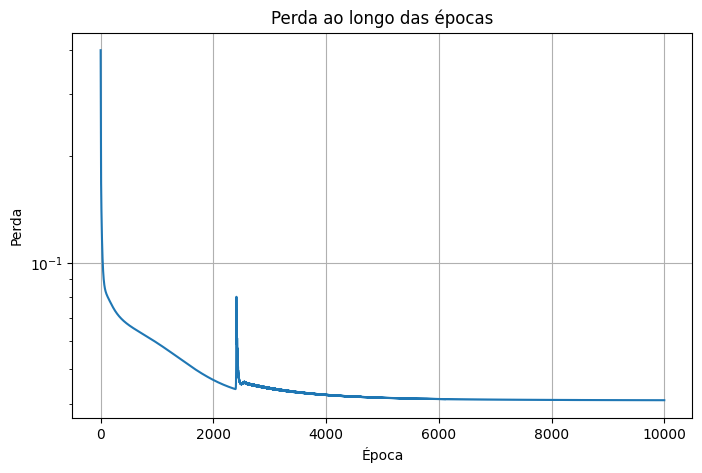

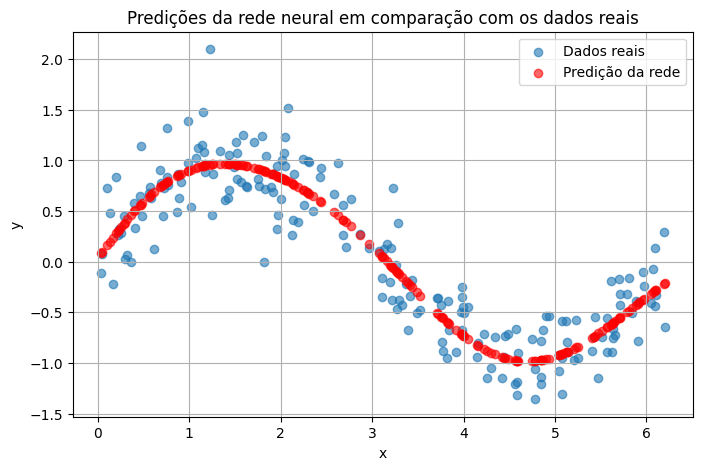

In [8]:
# Inicializando a rede neural com a função de ativação GELU
weights, biases, activation_functions, activations_derivatives = initialize_network(LAYERS, gelu, gelu_prime)

# Treinando a rede neural
loss_history, updated_weights, updated_biases = train_network(
    n_epochs=N_EPOCHS,
    learning_rate=LEARNING_RATE,
    activation_functions=activation_functions,
    activations_derivatives=activations_derivatives,
    weights=weights,
    biases=biases,
    lambda_l2=0  # Você pode ajustar este valor conforme necessário
)

# Plotando a curva de perda
plot_loss(loss_history)

# Plotando as predições da rede em comparação com os dados reais
plot_predictions(x_samples, y_samples, updated_weights, updated_biases, activation_functions)

# Avaliação da Rede Neural com Dados de Teste

Objetivo: Após treinar a rede neural com os dados de treinamento, é fundamental avaliar seu desempenho em um conjunto de dados de teste independente. Essa avaliação nos permite verificar a capacidade de generalização do modelo, ou seja, sua habilidade de realizar predições precisas em dados que não foram utilizados durante o treinamento.


Test Loss: 0.04209


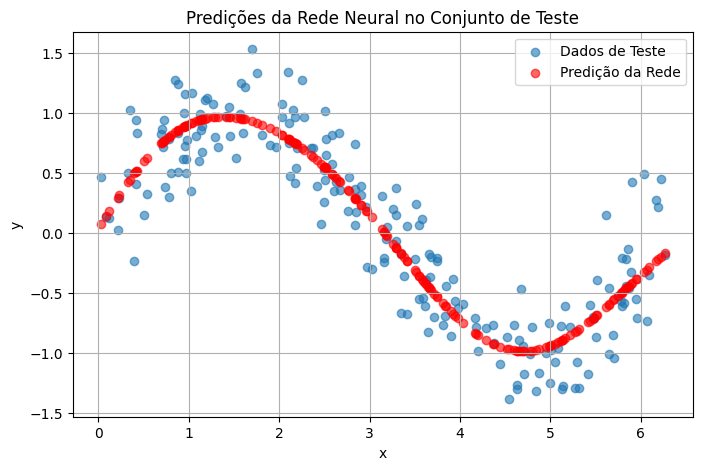

In [9]:
# Gerando dados de teste
x_test = np.random.uniform(0, 2 * np.pi, (1, 200))
y_test = np.sin(x_test) + np.random.normal(0.0, 0.3, (1, 200))

# Fazendo predições no conjunto de teste usando a rede treinada
y_pred_test = network_forward(x_test, weights, biases, activation_functions).flatten()

# Calculando a perda no conjunto de teste
test_loss = loss_forward(y_pred_test, y_test)
print(f"Test Loss: {test_loss:.5f}")

# Plotando as predições no conjunto de teste
plt.figure(figsize=(8, 5))
plt.scatter(x_test.flatten(), y_test.flatten(), label="Dados de Teste", alpha=0.6)
plt.scatter(x_test.flatten(), y_pred_test, label="Predição da Rede", color="red", alpha=0.6)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Predições da Rede Neural no Conjunto de Teste")
plt.grid(True)
plt.show()

# Tarefas de Experimentação

Abaixo, estão as tarefas que você deve realizar para explorar o comportamento da rede neural com diferentes parâmetros. Para cada tarefa, leia as instruções, faça as alterações sugeridas e observe como o desempenho da rede é afetado.

# Tarefa 1: Exploração de Funções de Ativação

**Instruções**

Nesta tarefa, você explorará o impacto de diferentes funções de ativação no desempenho da rede neural. A função de ativação controla como os neurônios transformam os dados de entrada, e diferentes funções podem influenciar a capacidade de aprendizado da rede.

	1.	Objetivo: Observar o impacto de diferentes funções de ativação.
	2.	Altere a função initialize_network para usar sigmoid ou relu como função de ativação no lugar de gelu.
	3.	Execute o treinamento e observe o comportamento da curva de perda para cada função.

  Obs:. Note que o LEARNING RATE foi ajustado para a função GELU



Treinando com ativação Sigmoid...
Epoch: 0, loss: 0.72701
Epoch: 100, loss: 0.29140
Epoch: 200, loss: 0.28773
Epoch: 300, loss: 0.28402
Epoch: 400, loss: 0.27944
Epoch: 500, loss: 0.27285
Epoch: 600, loss: 0.26235
Epoch: 700, loss: 0.24487
Epoch: 800, loss: 0.21633
Epoch: 900, loss: 0.17644
Epoch: 1000, loss: 0.13918
Epoch: 1100, loss: 0.11968
Epoch: 1200, loss: 0.11251
Epoch: 1300, loss: 0.10955
Epoch: 1400, loss: 0.10791
Epoch: 1500, loss: 0.10672
Epoch: 1600, loss: 0.10569
Epoch: 1700, loss: 0.10471
Epoch: 1800, loss: 0.10375
Epoch: 1900, loss: 0.10280
Epoch: 2000, loss: 0.10184
Epoch: 2100, loss: 0.10088
Epoch: 2200, loss: 0.09991
Epoch: 2300, loss: 0.09894
Epoch: 2400, loss: 0.09798
Epoch: 2500, loss: 0.09701
Epoch: 2600, loss: 0.09605
Epoch: 2700, loss: 0.09510
Epoch: 2800, loss: 0.09416
Epoch: 2900, loss: 0.09323
Epoch: 3000, loss: 0.09232
Epoch: 3100, loss: 0.09142
Epoch: 3200, loss: 0.09055
Epoch: 3300, loss: 0.08969
Epoch: 3400, loss: 0.08885
Epoch: 3500, loss: 0.08803
Epoch

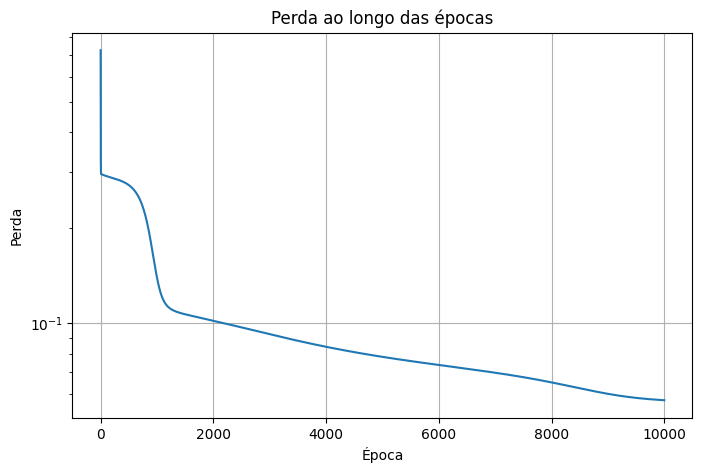

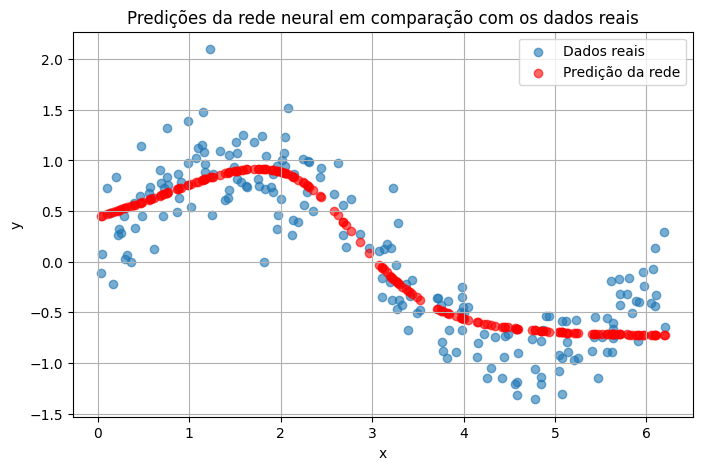


Treinando com ativação ReLU...
Epoch: 0, loss: 0.29636
Epoch: 100, loss: 0.09130
Epoch: 200, loss: 0.08488
Epoch: 300, loss: 0.07789
Epoch: 400, loss: 0.07302
Epoch: 500, loss: 0.06948
Epoch: 600, loss: 0.06375
Epoch: 700, loss: 0.05946
Epoch: 800, loss: 0.05528
Epoch: 900, loss: 0.05736
Epoch: 1000, loss: 0.05170
Epoch: 1100, loss: 0.04953
Epoch: 1200, loss: 0.05366
Epoch: 1300, loss: 0.05391
Epoch: 1400, loss: 0.05063
Epoch: 1500, loss: 0.05230
Epoch: 1600, loss: 0.04963
Epoch: 1700, loss: 0.04958
Epoch: 1800, loss: 0.04566
Epoch: 1900, loss: 0.04432
Epoch: 2000, loss: 0.04376
Epoch: 2100, loss: 0.04488
Epoch: 2200, loss: 0.04482
Epoch: 2300, loss: 0.04304
Epoch: 2400, loss: 0.04422
Epoch: 2500, loss: 0.04326
Epoch: 2600, loss: 0.04274
Epoch: 2700, loss: 0.04208
Epoch: 2800, loss: 0.04287
Epoch: 2900, loss: 0.04259
Epoch: 3000, loss: 0.04495
Epoch: 3100, loss: 0.04170
Epoch: 3200, loss: 0.04147
Epoch: 3300, loss: 0.04323
Epoch: 3400, loss: 0.04181
Epoch: 3500, loss: 0.04204
Epoch: 3

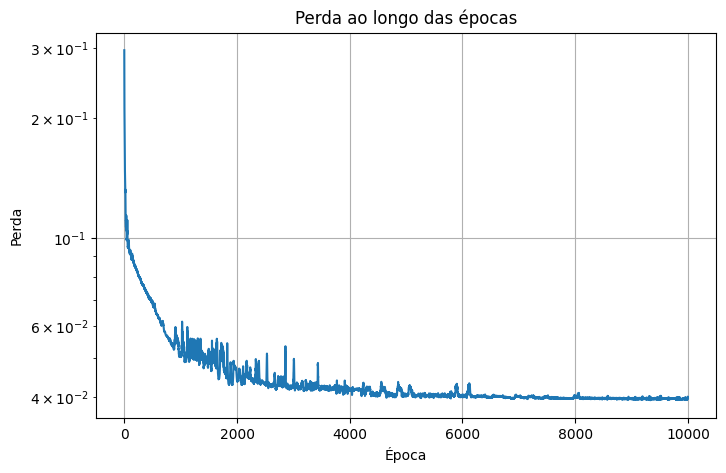

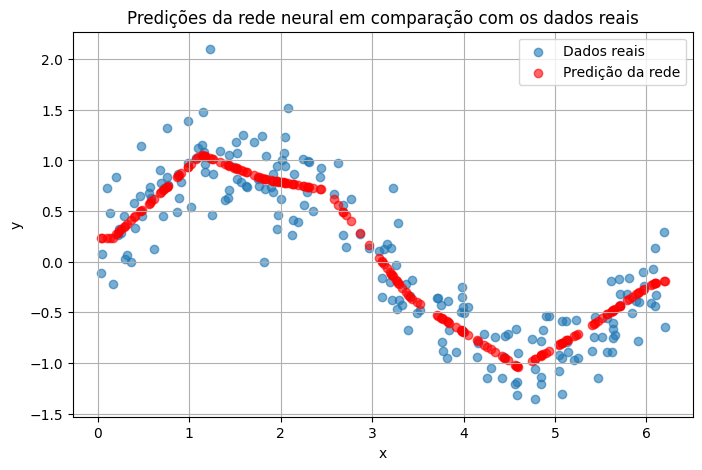

In [ ]:
# Função de visualização de separação
def initialize_and_train(layers, activation_func, activation_derivative, lr, epochs, x_train, y_train, label):
    """
    Inicializa a rede com uma função de ativação específica, treina e plota os resultados.

    Args:
        layers (list): Arquitetura da rede.
        activation_func (function): Função de ativação.
        activation_derivative (function): Derivada da função de ativação.
        lr (float): Taxa de aprendizado.
        epochs (int): Número de épocas de treinamento.
        x_train (numpy.ndarray): Dados de entrada para treinamento.
        y_train (numpy.ndarray): Dados de saída para treinamento.
        label (str): Rótulo para identificação da função de ativação.

    Returns:
        updated_weights (list): Pesos atualizados após o treinamento.
        updated_biases (list): Biases atualizados após o treinamento.
    """
    weights, biases, activation_functions, activations_derivatives = initialize_network(layers, activation_func, activation_derivative)
    print(f"\nTreinando com ativação {label}...")
    loss_history, updated_weights, updated_biases = train_network(
        epochs,
        lr,
        activation_functions,
        activations_derivatives,
        weights,
        biases
    )
    plot_loss(loss_history)
    plot_predictions(x_train, y_train, updated_weights, updated_biases, activation_functions)
    return updated_weights, updated_biases  # Retorna pesos e biases atualizados, se necessário
relu_learning_rate=0.1 # => ajuste o lr para a Sigmoid e ReLU
# Testando com ativação Sigmoid
updated_weights_sigmoid, updated_biases_sigmoid = initialize_and_train(
    layers=LAYERS,
    activation_func=sigmoid,
    activation_derivative=sigmoid_prime,
    lr=relu_learning_rate,
    epochs=N_EPOCHS,
    x_train=x_samples,
    y_train=y_samples,
    label="Sigmoid"
)

# Testando com ativação ReLU
updated_weights_relu, updated_biases_relu = initialize_and_train(
    layers=LAYERS,
    activation_func=relu,
    activation_derivative=relu_prime,
    lr=relu_learning_rate,
    epochs=N_EPOCHS,
    x_train=x_samples,
    y_train=y_samples,
    label="ReLU"

)

# Tarefa 2: Variação do Número de Épocas

Objetivo: Analisar como a quantidade de épocas de treinamento influencia o desempenho da rede neural na aproximação da função seno. Observaremos como diferentes números de épocas afetam a convergência da perda e a qualidade das predições da rede.



In [ ]:
# Tarefa 2: Variação do Número de Épocas
LEARNING_RATE = 0.05 # Voltando o learning rate para a função Gelu

# Definindo diferentes números de épocas para treinamento
epochs_list = [1000, 5000, 10000, 20000]

# Armazenando os históricos de perda para cada configuração
loss_histories = {}

# Gerando dados de teste
x_test = np.random.uniform(0, 2 * np.pi, (1, 200))
y_test_real = np.sin(x_test)
y_test = y_test_real + np.random.normal(0.0, 0.3, (1, 200))

for epochs in epochs_list:
    print(f"\nTreinando com {epochs} épocas...")
    # Inicializando a rede neural com a função de ativação GELU
    weights, biases, activation_functions, activations_derivatives = initialize_network(LAYERS, gelu, gelu_prime)

    # Treinando a rede neural
    loss_history, updated_weights, updated_biases = train_network(
        n_epochs=epochs,
        learning_rate=LEARNING_RATE,
        activation_functions=activation_functions,
        activations_derivatives=activations_derivatives,
        weights=weights,
        biases=biases,
        lambda_l2=0  # Sem regularização L2 nesta tarefa
    )

    # Armazenando o histórico de perda
    loss_histories[epochs] = loss_history

    y_pred_test = network_forward(x_test, weights, biases, activation_functions).flatten()

    # Plotando as predições da rede em comparação com os dados empíricos reais
    test_loss = loss_forward(y_pred_test, y_test)
    print(f"Test Loss: {test_loss:.5f}")
    real_test_loss = loss_forward(y_pred_test, y_test_real)
    print(f"\"Real\" Test Loss: {real_test_loss:.5f}")

    plot_predictions(x_test, y_test, updated_weights, updated_biases, activation_functions)

# Plotando todas as curvas de perda em um único gráfico para comparação
plt.figure(figsize=(10, 6))
for epochs, loss_history in loss_histories.items():
    plt.plot(loss_history, label=f"{epochs} Épocas")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.yscale("log")
plt.title("Comparação das Curvas de Perda com Diferente Número de Épocas")
plt.legend()
plt.grid(True)
plt.show()


# Tarefa 3: Influência da Taxa de Aprendizado

Objetivo:Investigar como diferentes taxas de aprendizado (learning_rate) afetam a convergência e o desempenho da rede neural. Analisaremos como a velocidade e a estabilidade do treinamento variam com a alteração dessa taxa.

In [ ]:
# Tarefa 3: Influência da Taxa de Aprendizado

# Definindo diferentes taxas de aprendizado para treinamento
learning_rates = [0.001, 0.01, 0.05, 0.1]

# Armazenando os históricos de perda para cada configuração
loss_histories_lr = {}

for lr in learning_rates:
    print(f"\nTreinando com Taxa de Aprendizado: {lr}")
    # Inicializando a rede neural com a função de ativação GELU
    weights, biases, activation_functions, activations_derivatives = initialize_network(LAYERS, gelu, gelu_prime)

    # Treinando a rede neural
    loss_history, updated_weights, updated_biases = train_network(
        n_epochs=N_EPOCHS,
        learning_rate=lr,
        activation_functions=activation_functions,
        activations_derivatives=activations_derivatives,
        weights=weights,
        biases=biases,
        lambda_l2=0  # Sem regularização L2 nesta tarefa
    )

    # Armazenando o histórico de perda
    loss_histories_lr[lr] = loss_history

    # Plotando as predições da rede em comparação com os dados reais
    plot_predictions(x_samples, y_samples, updated_weights, updated_biases, activation_functions)

# Plotando todas as curvas de perda em um único gráfico para comparação
plt.figure(figsize=(10, 6))
for lr, loss_history in loss_histories_lr.items():
    plt.plot(loss_history, label=f"LR={lr}")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.yscale("log")
plt.title("Comparação das Curvas de Perda com Diferentes Taxas de Aprendizado")
plt.legend()
plt.grid(True)
plt.show()

# Tarefa 4: Ajuste do Número de Neurônios por Camada

Objetivo: Avaliar como a quantidade de neurônios em cada camada oculta influencia a capacidade de aprendizagem e a performance da rede neural. Exploraremos diferentes arquiteturas para entender o impacto da complexidade da rede.

In [ ]:
# Tarefa 4: Ajuste do Número de Neurônios por Camada

# Definindo diferentes configurações de número de neurônios por camada
neurons_configurations = [
    [1, 5, 5, 5, 1],
    [1, 10, 10, 10, 1],
    [1, 20, 20, 20, 1],
    [1, 50, 50, 50, 1]
]

# Armazenando os históricos de perda para cada configuração
loss_histories_neurons = {}
time_histories_neurons = {}

for neurons in neurons_configurations:
    print(f"\nTreinando com configuração de neurônios: {neurons}")
    # Inicializando a rede neural com a função de ativação GELU
    weights, biases, activation_functions, activations_derivatives = initialize_network(neurons, gelu, gelu_prime)

    # Treinando a rede neural
    before_exe = arrow.now()
    loss_history, updated_weights, updated_biases = train_network(
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        activation_functions=activation_functions,
        activations_derivatives=activations_derivatives,
        weights=weights,
        biases=biases,
        lambda_l2=0  # Sem regularização L2 nesta tarefa
    )
    after_exe = arrow.now()

    # Armazenando o histórico de perda
    loss_histories_neurons[tuple(neurons)] = loss_history
    time_histories_neurons[tuple(neurons)] = after_exe - before_exe

    # Plotando as predições da rede em comparação com os dados reais
    plot_predictions(x_samples, y_samples, updated_weights, updated_biases, activation_functions)

# Plotando todas as curvas de perda em um único gráfico para comparação
plt.figure(figsize=(10, 6))
for neurons, loss_history in loss_histories_neurons.items():
    plt.plot(loss_history, label=f"Neurônios={neurons}")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.yscale("log")
plt.title("Comparação das Curvas de Perda com Diferente Número de Neurônios por Camada")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(time_histories_neurons)
plt.figure(figsize=(10, 6))
x_neurons, y_time = zip(*[(str(neurons), time.seconds) for neurons, time in time_histories_neurons.items()])
y_time
plt.bar(x_neurons, y_time)
plt.xlabel("Neurônios")
plt.ylabel("Tempo")
plt.title("Tempo das diversas redes")
plt.legend()
plt.grid(True)
plt.show()


# Tarefa 5: Introdução de Ruído nos Dados de Treinamento
Objetivo: Investigar como diferentes níveis de ruído nos dados de treinamento afetam a performance e a generalização da rede neural. Avaliaremos a robustez do modelo frente a dados ruidosos.

In [ ]:
# Tarefa 5: Introdução de Ruído nos Dados de Treinamento

# Definindo diferentes níveis de ruído (desvio padrão)
noise_levels = [0.0, 0.1, 0.3, 0.5]

# Armazenando os históricos de perda para cada configuração
loss_histories_noise = {}

for noise_std in noise_levels:
    print(f"\nTreinando com nível de ruído: σ={noise_std}")
    # Gerando dados com o nível de ruído especificado
    y_samples_noisy = np.sin(x_samples) + np.random.normal(0.0, noise_std, (1, N_SAMPLES))

    # Visualizando os dados com ruído
    plt.figure(figsize=(8, 5))
    plt.scatter(x_samples.flatten(), y_samples_noisy.flatten(), label=f"Dados com Ruído σ={noise_std}", alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(f"Dados de Treinamento com Ruído σ={noise_std}")
    plt.grid(True)
    plt.show()

    # Inicializando a rede neural com a função de ativação GELU
    weights, biases, activation_functions, activations_derivatives = initialize_network(LAYERS, gelu, gelu_prime)

    # Treinando a rede neural
    loss_history, updated_weights, updated_biases = train_network(
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        activation_functions=activation_functions,
        activations_derivatives=activations_derivatives,
        weights=weights,
        biases=biases,
        lambda_l2=0  # Sem regularização L2 nesta tarefa
    )

    # Armazenando o histórico de perda
    loss_histories_noise[noise_std] = loss_history

    # Plotando as predições da rede em comparação com os dados reais com ruído
    plot_predictions(x_samples, y_samples_noisy, updated_weights, updated_biases, activation_functions)

# Plotando todas as curvas de perda em um único gráfico para comparação
plt.figure(figsize=(10, 6))
for noise_std, loss_history in loss_histories_noise.items():
    plt.plot(loss_history, label=f"Ruído σ={noise_std}")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.yscale("log")
plt.title("Comparação das Curvas de Perda com Diferente Níveis de Ruído")
plt.legend()
plt.grid(True)
plt.show()

# Tarefa 6: Aplicação de Regularização L2

Objetivo: Avaliar como a aplicação da regularização L2 (lambda_l2) influencia o treinamento da rede neural, ajudando a prevenir o overfitting. Exploraremos diferentes valores de lambda para entender seu impacto no desempenho da rede.

In [11]:
class TrainedNN:
    """Para armazenar uma rede neural treinada"""

    def TrainedNN(self, weights, biases):
        self.weights = weights
        self.biases = biases


Treinando com Regularização L2: λ=0.0
Epoch: 0, loss: 1.40841
Epoch: 100, loss: 0.09268
Epoch: 200, loss: 0.08234
Epoch: 300, loss: 0.07303
Epoch: 400, loss: 0.06276
Epoch: 500, loss: 0.05411
Epoch: 600, loss: 0.04870
Epoch: 700, loss: 0.04651
Epoch: 800, loss: 0.04467
Epoch: 900, loss: 0.04389
Epoch: 1000, loss: 0.04469
Epoch: 1100, loss: 0.04303
Epoch: 1200, loss: 0.04277
Epoch: 1300, loss: 0.04273
Epoch: 1400, loss: 0.04230
Epoch: 1500, loss: 0.04212
Epoch: 1600, loss: 0.04205
Epoch: 1700, loss: 0.04190
Epoch: 1800, loss: 0.04173
Epoch: 1900, loss: 0.04164
Epoch: 2000, loss: 0.04156
Epoch: 2100, loss: 0.04147
Epoch: 2200, loss: 0.04139
Epoch: 2300, loss: 0.04132
Epoch: 2400, loss: 0.04126
Epoch: 2500, loss: 0.04121
Epoch: 2600, loss: 0.04116
Epoch: 2700, loss: 0.04112
Epoch: 2800, loss: 0.04108
Epoch: 2900, loss: 0.04105
Epoch: 3000, loss: 0.04102
Epoch: 3100, loss: 0.04099
Epoch: 3200, loss: 0.04096
Epoch: 3300, loss: 0.04094
Epoch: 3400, loss: 0.04092
Epoch: 3500, loss: 0.04090
E

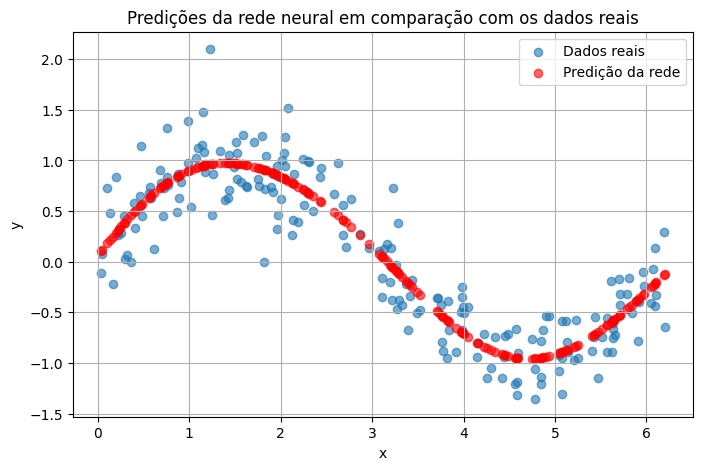


Treinando com Regularização L2: λ=0.001
Epoch: 0, loss: 0.29790
Epoch: 100, loss: 0.11825
Epoch: 200, loss: 0.11155
Epoch: 300, loss: 0.10596
Epoch: 400, loss: 0.09946
Epoch: 500, loss: 0.09799
Epoch: 600, loss: 0.09327
Epoch: 700, loss: 0.09185
Epoch: 800, loss: 0.27518
Epoch: 900, loss: 0.08634
Epoch: 1000, loss: 0.09023
Epoch: 1100, loss: 0.08167
Epoch: 1200, loss: 0.08129
Epoch: 1300, loss: 0.07782
Epoch: 1400, loss: 0.07664
Epoch: 1500, loss: 0.07542
Epoch: 1600, loss: 0.07615
Epoch: 1700, loss: 0.07966
Epoch: 1800, loss: 0.07480
Epoch: 1900, loss: 0.07377
Epoch: 2000, loss: 0.07302
Epoch: 2100, loss: 0.07230
Epoch: 2200, loss: 0.07165
Epoch: 2300, loss: 0.07106
Epoch: 2400, loss: 0.07052
Epoch: 2500, loss: 0.07004
Epoch: 2600, loss: 0.06961
Epoch: 2700, loss: 0.06922
Epoch: 2800, loss: 0.06885
Epoch: 2900, loss: 0.06851
Epoch: 3000, loss: 0.06819
Epoch: 3100, loss: 0.06789
Epoch: 3200, loss: 0.06760
Epoch: 3300, loss: 0.06732
Epoch: 3400, loss: 0.06706
Epoch: 3500, loss: 0.06681

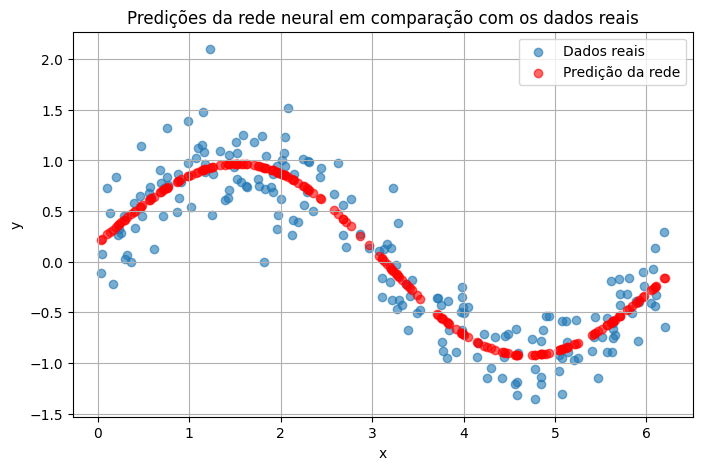


Treinando com Regularização L2: λ=0.01
Epoch: 0, loss: 0.50843
Epoch: 100, loss: 0.31822
Epoch: 200, loss: 0.29822
Epoch: 300, loss: 0.28146
Epoch: 400, loss: 0.26676
Epoch: 500, loss: 0.25374
Epoch: 600, loss: 0.24210
Epoch: 700, loss: 0.23162
Epoch: 800, loss: 0.22213
Epoch: 900, loss: 0.21349
Epoch: 1000, loss: 0.20561
Epoch: 1100, loss: 0.19841
Epoch: 1200, loss: 0.19180
Epoch: 1300, loss: 0.18573
Epoch: 1400, loss: 0.18015
Epoch: 1500, loss: 0.17501
Epoch: 1600, loss: 0.17027
Epoch: 1700, loss: 0.16589
Epoch: 1800, loss: 0.16185
Epoch: 1900, loss: 0.15810
Epoch: 2000, loss: 0.15463
Epoch: 2100, loss: 0.15142
Epoch: 2200, loss: 0.14844
Epoch: 2300, loss: 0.14568
Epoch: 2400, loss: 0.14311
Epoch: 2500, loss: 0.14072
Epoch: 2600, loss: 0.13851
Epoch: 2700, loss: 0.13644
Epoch: 2800, loss: 0.13451
Epoch: 2900, loss: 0.13272
Epoch: 3000, loss: 0.13103
Epoch: 3100, loss: 0.12946
Epoch: 3200, loss: 0.12799
Epoch: 3300, loss: 0.12660
Epoch: 3400, loss: 0.12530
Epoch: 3500, loss: 0.12407


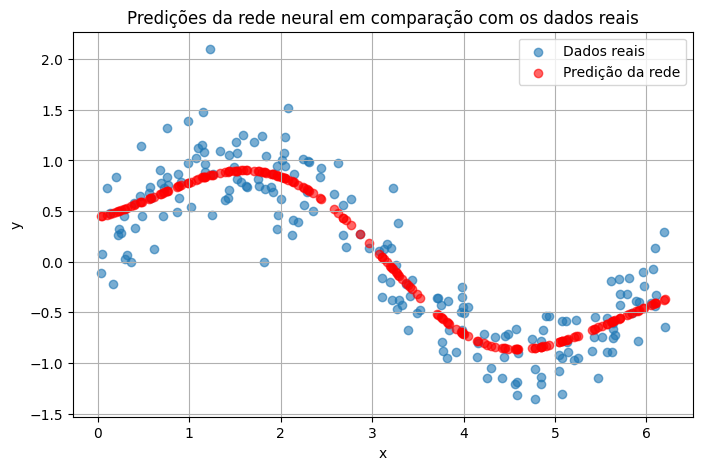


Treinando com Regularização L2: λ=0.1
Epoch: 0, loss: 2.92893
Epoch: 100, loss: 1.14707
Epoch: 200, loss: 0.63066
Epoch: 300, loss: 0.43199
Epoch: 400, loss: 0.35531
Epoch: 500, loss: 0.32564
Epoch: 600, loss: 0.31371
Epoch: 700, loss: 0.30850
Epoch: 800, loss: 0.30594
Epoch: 900, loss: 0.30450
Epoch: 1000, loss: 0.30360
Epoch: 1100, loss: 0.30297
Epoch: 1200, loss: 0.30251
Epoch: 1300, loss: 0.30215
Epoch: 1400, loss: 0.30186
Epoch: 1500, loss: 0.30163
Epoch: 1600, loss: 0.30144
Epoch: 1700, loss: 0.30127
Epoch: 1800, loss: 0.30113
Epoch: 1900, loss: 0.30101
Epoch: 2000, loss: 0.30091
Epoch: 2100, loss: 0.30082
Epoch: 2200, loss: 0.30074
Epoch: 2300, loss: 0.30067
Epoch: 2400, loss: 0.30061
Epoch: 2500, loss: 0.30055
Epoch: 2600, loss: 0.30050
Epoch: 2700, loss: 0.30046
Epoch: 2800, loss: 0.30042
Epoch: 2900, loss: 0.30039
Epoch: 3000, loss: 0.30036
Epoch: 3100, loss: 0.30033
Epoch: 3200, loss: 0.30030
Epoch: 3300, loss: 0.30028
Epoch: 3400, loss: 0.30026
Epoch: 3500, loss: 0.30024
E

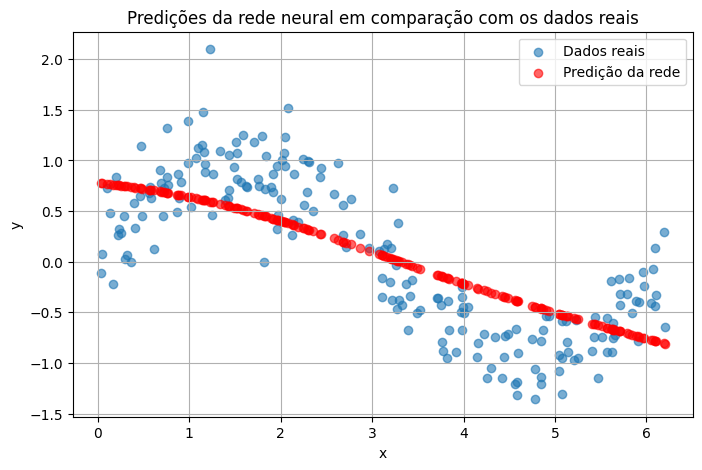

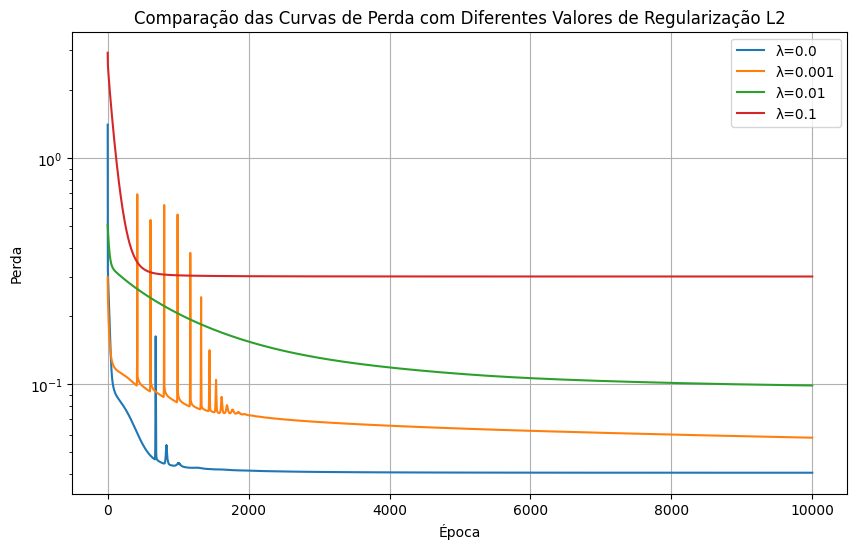

In [10]:
# Tarefa 6: Aplicação de Regularização L2

# Definindo diferentes valores de lambda para regularização L2
lambda_l2_values = [0.0, 0.001, 0.01, 0.1]

# Armazenando os históricos de perda para cada configuração
loss_histories_l2 = {}

for lambda_l2 in lambda_l2_values:
    print(f"\nTreinando com Regularização L2: λ={lambda_l2}")
    # Inicializando a rede neural com a função de ativação GELU
    weights, biases, activation_functions, activations_derivatives = initialize_network(LAYERS, gelu, gelu_prime)

    # Treinando a rede neural com regularização L2
    loss_history, updated_weights, updated_biases = train_network(
        n_epochs=N_EPOCHS,
        learning_rate=LEARNING_RATE,
        activation_functions=activation_functions,
        activations_derivatives=activations_derivatives,
        weights=weights,
        biases=biases,
        lambda_l2=lambda_l2  # Aplicando regularização L2
    )

    # Armazenando o histórico de perda
    loss_histories_l2[lambda_l2] = loss_history

    # Plotando as predições da rede em comparação com os dados reais
    plot_predictions(x_samples, y_samples, updated_weights, updated_biases, activation_functions)

# Plotando todas as curvas de perda em um único gráfico para comparação
plt.figure(figsize=(10, 6))
for lambda_l2, loss_history in loss_histories_l2.items():
    plt.plot(loss_history, label=f"λ={lambda_l2}")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.yscale("log")
plt.title("Comparação das Curvas de Perda com Diferentes Valores de Regularização L2")
plt.legend()
plt.grid(True)
plt.show()